# 2. Modeling (대기질지수 / 이용시간 예측) 

> ## Contents  
  * 1) 미세먼지·초미세먼지 예측모델 및 대기질지수 생성
  * 2) 이용시간 예측모델

### Pycaret 패키지 설치
* PyCaret은 파이썬의 오픈 소스 Low-code 머신 러닝 라이브러리입니다. 많은 모델들을 비교하여 결과값을 보여줌으로써, 손쉬운 모델 선정 및 생성을 가능합니다

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install pycaret==2.2.3
import pycaret
from pycaret.regression import *

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# 1) 이용시간 예측모델 

## a) 버스정류장별 고정데이터 및 예측된 이용시간 데이터 로드

In [ ]:
이용시간_cluster = pd.read_csv("이용시간_cluster.csv")
이용시간_train = pd.read_csv("이용시간_train.csv")
이용시간_test = pd.read_csv("이용시간_test.csv")

## b) 버스정류장 고정 정보로 Clustering

In [ ]:
# 버스정류장의 고정 정보로만 clustering

X = 이용시간_cluster[['노선개수','인구수_유소년', '인구수_생산가능', '인구수_고령','혼잡빈도강도', '혼잡시간강도', 
              '학교_5분이내개수', '집_5분이내개수', '회사_5분이내개수', '공장_5분이내개수', '상업시설_5분이내개수', '관공서_5분이내개수', 
              '지하철_5분이내개수', '병원_5분이내개수']]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)

In [ ]:
# 클러스터링 방법으로 k-means를 사용함

kmeans = KMeans(n_clusters=3, random_state=1234, max_iter=300).fit(X_scaled)
silhouette_score(X_scaled, eval('kmeans').labels_)

0.1488656795712316

Text(0.5, 1.0, '클러스터별 Centriod 시각화')

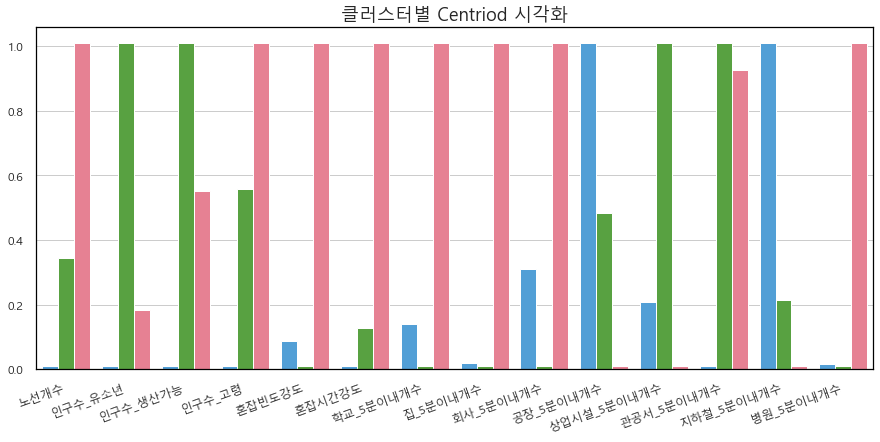

In [ ]:
# 클러스터별 centroid 시각화

plt.rcParams["font.family"] = 'Malgun Gothic'  
plt.rcParams.update({"figure.figsize" : (11, 6),"axes.facecolor" : "white","axes.edgecolor":  "black"})
cmap = sns.color_palette("husl", 3)
cmap.reverse()

tmp = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
tmp = ((tmp - tmp.min()) / (tmp.max() - tmp.min()) + 0.01).reset_index()
value = []
for i in list(tmp.columns)[1:]:
    tmp_col = tmp[["index",i]].rename(columns = {"index" : "cluster", i : "centroid"})
    tmp_col["x"] = i
    value.append(tmp_col)

fig,ax = plt.subplots(figsize = (15,7))
fig.autofmt_xdate(rotation=20)
sns.barplot(data = pd.concat(value), x = "x", y = "centroid", hue = "cluster", ax=ax, palette=cmap)
ax.get_legend().remove()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("")
plt.ylabel("")
plt.title("클러스터별 Centriod 시각화",fontsize=18)

In [ ]:
cluster_ids = kmeans.fit_predict(X_scaled)
kmeans_df = pd.concat([이용시간_cluster['정류소ID'],X,pd.Series(cluster_ids)],axis=1)
kmeans_df.rename(columns={0:'Cluster'},inplace=True)
kmeans_df['Cluster'].value_counts()

0    237
1    231
2    230
Name: Cluster, dtype: int64

In [ ]:
df_이용시간예측 = 이용시간_train.merge(kmeans_df[['정류소ID','Cluster']],on='정류소ID',how='inner')

In [ ]:
df_이용시간예측.to_csv("df_이용시간예측_클러스터.csv",index=False)

## c) Cluster 1에 속하는 버스정류장 모델링 및 예측

In [ ]:
import pycaret
from pycaret.regression import *

In [ ]:
df_이용시간예측=pd.read_csv("df_이용시간예측_클러스터.csv")

In [ ]:
X0 = df_이용시간예측[df_이용시간예측['Cluster']==0].drop(['일자','정류소ID','월','요일','전체 승차 건수','최종배차','lon','lat','Cluster'],axis=1)
X0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19852 entries, 0 to 58291
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   주말여부           19852 non-null  float64
 1   이용시간           19852 non-null  float64
 2   혼잡시간강도         19852 non-null  float64
 3   혼잡빈도강도         19852 non-null  float64
 4   width          19852 non-null  float64
 5   학교_5분이내거리평균    19852 non-null  float64
 6   집_5분이내거리평균     19852 non-null  float64
 7   회사_5분이내거리평균    19852 non-null  float64
 8   공장_5분이내거리평균    19852 non-null  float64
 9   상업시설_5분이내거리평균  19852 non-null  float64
 10  관공서_5분이내거리평균   19852 non-null  float64
 11  지하철_5분이내거리평균   19852 non-null  float64
 12  학교_5분이내개수      19852 non-null  float64
 13  집_5분이내개수       19852 non-null  float64
 14  회사_5분이내개수      19852 non-null  float64
 15  공장_5분이내개수      19852 non-null  float64
 16  상업시설_5분이내개수    19852 non-null  float64
 17  관공서_5분이내개수     19852 non-null  float64
 18  지하철_5분

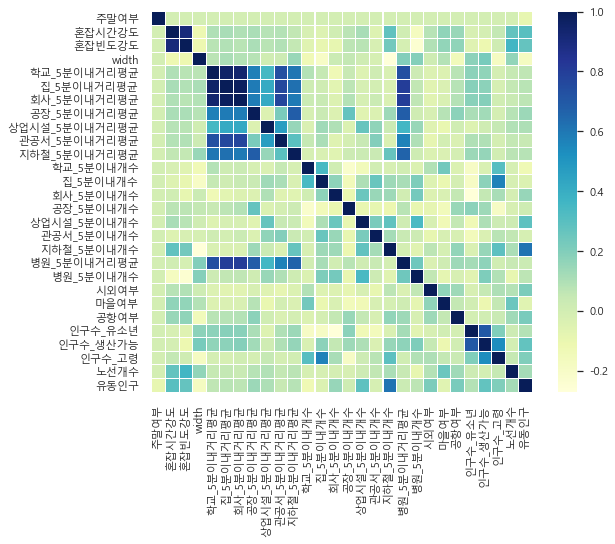

In [ ]:
# Cluster 1에 해당하는 버스정류장별 변수들의 Correlation Plot

plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 7))
sns.heatmap(X0.drop('이용시간',axis=1).corr(), linewidths = 0.1, vmax = 1.0, square = True, linecolor = "white", cmap="YlGnBu")
sns.set(rc={"axes.unicode_minus":False})

* 변수들간의 상관계수가 높아 Auto ML의 세팅에서 다중공선성 제거를 True로 두고 진행하였다. 

In [ ]:
exp1 = setup(X0, target='이용시간', normalize = True, numeric_features=['노선개수','width','상업시설_5분이내개수','공장_5분이내개수',
                                                                   '관공서_5분이내개수','지하철_5분이내개수','병원_5분이내개수'],
             feature_selection=True, verbose=True, remove_multicollinearity = True)

,Description,Value
0,session_id,6539
1,Target,이용시간
2,Original Data,"(19852, 29)"
3,Missing Values,False
4,Numeric Features,24
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(13896, 24)"


* Cluster 1의 Random Forest 학습 결과

In [ ]:
rf_0 = create_model('rf', verbose=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,310.6513,678955.7949,823.9877,0.9776,0.2134,0.1576
1,297.4519,439372.1520,662.8515,0.9836,0.2113,0.1584
2,328.4458,747329.8312,864.4824,0.9583,0.2287,0.1679
3,303.1842,728383.2164,853.4537,0.9780,0.2093,0.1578
4,298.5705,577365.6465,759.8458,0.9790,0.2123,0.1574
5,311.3652,666034.3181,816.1093,0.9786,0.2087,0.1556
6,328.3530,700282.1985,836.8287,0.9789,0.2178,0.1614
7,313.5710,684842.9999,827.5524,0.9840,0.2188,0.1628
8,311.8708,595204.1763,771.4948,0.9815,0.2110,0.1596
9,290.3044,492083.4786,701.4866,0.9818,0.2163,0.1599


* 변수간의 상관계수가 감소하여 다중공선성이 완화되었음을 알 수 있다.

<AxesSubplot:>

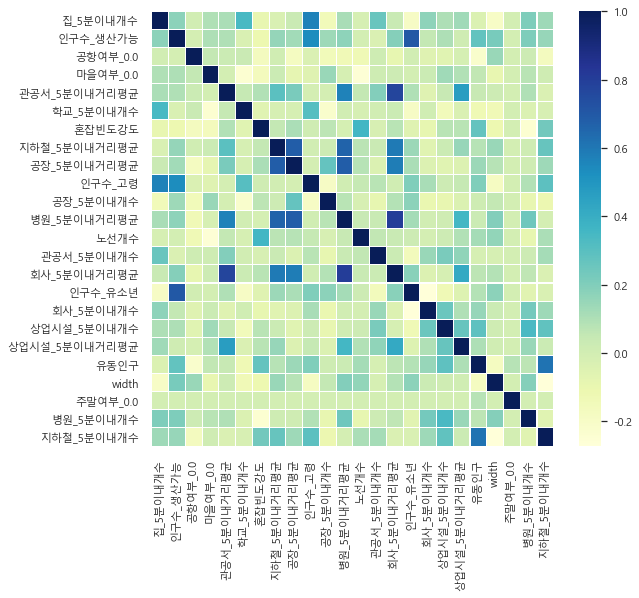

In [ ]:
corrmat = exp1[15].corr()
plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

* Cluster 1에 속하는 버스정류장들의 이용시간 모델의 Feature Importance

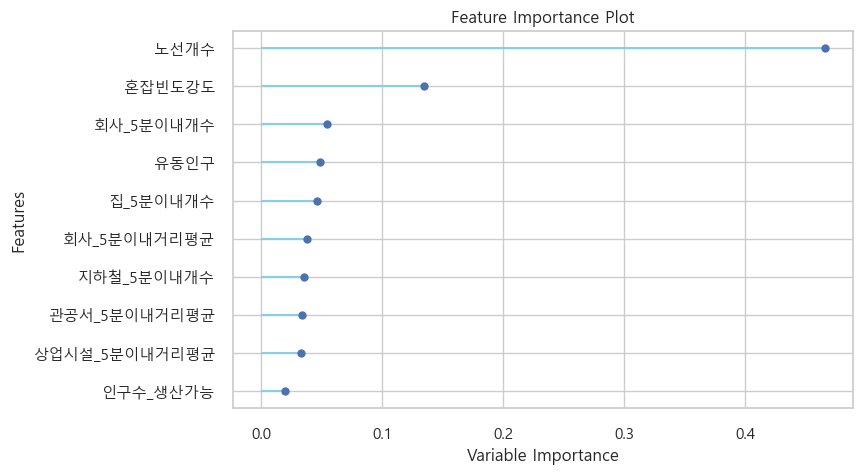

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'Malgun Gothic'
plot_model(rf_0, plot='feature')

In [ ]:
cluster0_ID = df_이용시간예측[df_이용시간예측['Cluster']==0]['정류소ID'].unique()
test_cluster0 = 이용시간_test[이용시간_test['정류소ID'].isin(cluster0_ID)]
pred_cluster0 = predict_model(rf_0, data = test_cluster0)
pred_cluster0.Label.describe()

count     4977.000000
mean      2167.056593
std       5102.945207
min         28.228750
25%        409.687215
50%        842.279091
75%       1935.565815
max      58934.902158
Name: Label, dtype: float64

## d) Cluster 2에 속하는 버스정류장 모델링 및 예측

In [ ]:
X1 = df_이용시간예측[df_이용시간예측['Cluster']==1].drop(['일자','정류소ID','월','요일','전체 승차 건수','최종배차','lon','lat','Cluster'],axis=1)
X1

,주말여부,이용시간,혼잡시간강도,혼잡빈도강도,width,학교_5분이내거리평균,집_5분이내거리평균,회사_5분이내거리평균,공장_5분이내거리평균,상업시설_5분이내거리평균,...,병원_5분이내거리평균,병원_5분이내개수,시외여부,마을여부,공항여부,인구수_유소년,인구수_생산가능,인구수_고령,노선개수,유동인구
336,0.0,495.575000,70.47,42.25,3.0,0.002977,0.003889,0.003284,0.0,0.004535,...,0.004146,1.0,0.0,1.0,0.0,2384.0,15808.0,2857.0,1.0,35411.74
337,0.0,509.550000,70.47,42.25,3.0,0.002977,0.003889,0.003284,0.0,0.004535,...,0.004146,1.0,0.0,1.0,0.0,2384.0,15808.0,2857.0,1.0,38324.24
338,0.0,540.725000,70.47,42.25,3.0,0.002977,0.003889,0.003284,0.0,0.004535,...,0.004146,1.0,0.0,1.0,0.0,2384.0,15808.0,2857.0,1.0,37501.21
339,0.0,408.500000,70.47,42.25,3.0,0.002977,0.003889,0.003284,0.0,0.004535,...,0.004146,1.0,0.0,1.0,0.0,2384.0,15808.0,2857.0,1.0,39066.62
340,0.0,489.125000,70.47,42.25,3.0,0.002977,0.003889,0.003284,0.0,0.004535,...,0.004146,1.0,0.0,1.0,0.0,2384.0,15808.0,2857.0,1.0,37558.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58203,0.0,9761.016081,33.07,6.39,2.0,0.003182,0.003265,0.000000,0.0,0.000000,...,0.000000,0.0,1.0,1.0,0.0,3145.0,14642.0,880.0,13.0,118279.46
58204,0.0,9525.410541,33.07,6.39,2.0,0.003182,0.003265,0.000000,0.0,0.000000,...,0.000000,0.0,1.0,1.0,0.0,3145.0,14642.0,880.0,13.0,122113.01
58205,0.0,7932.502252,33.07,6.39,2.0,0.003182,0.003265,0.000000,0.0,0.000000,...,0.000000,0.0,1.0,1.0,0.0,3145.0,14642.0,880.0,13.0,124539.53
58206,1.0,3891.395439,33.07,6.39,2.0,0.003182,0.003265,0.000000,0.0,0.000000,...,0.000000,0.0,1.0,1.0,0.0,3145.0,14642.0,880.0,13.0,123781.03


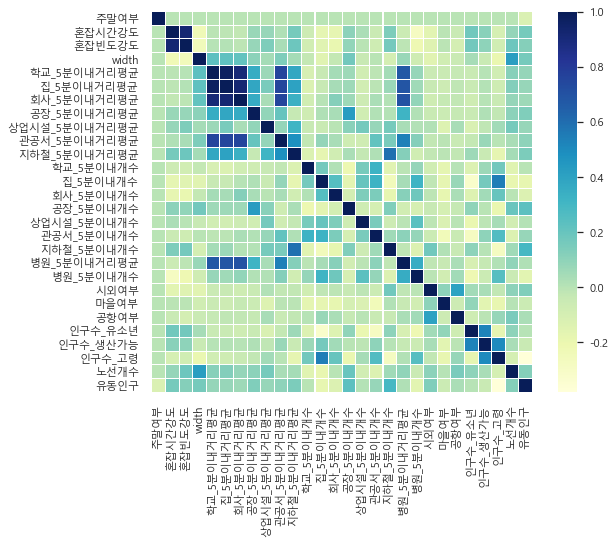

In [ ]:
# Cluster 2에 해당하는 버스정류장별 변수들의 Correlation Plot

plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 7))
sns.heatmap(X1.drop('이용시간',axis=1).corr(), linewidths = 0.1, vmax = 1.0, square = True, linecolor = "white", cmap="YlGnBu")
sns.set(rc={"axes.unicode_minus":False})

* 변수들간의 상관계수가 높아 Auto ML의 세팅에서 다중공선성 제거를 True로 두고 진행하였다. 

In [ ]:
exp2 = setup(X1, target='이용시간', normalize = True, numeric_features=['노선개수','width','상업시설_5분이내개수','공장_5분이내개수',
                                                                   '관공서_5분이내개수','지하철_5분이내개수','병원_5분이내개수'],
             feature_selection=True, verbose=True, remove_multicollinearity = True)

,Description,Value
0,session_id,4757
1,Target,이용시간
2,Original Data,"(19288, 29)"
3,Missing Values,False
4,Numeric Features,24
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(13501, 25)"


* Cluster 2의 Random Forest 학습 결과

In [ ]:
rf_1 = create_model('rf',verbose=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,297.4918,321872.3270,567.3379,0.9632,0.2047,0.1550
1,291.7021,297567.4667,545.4974,0.9635,0.2161,0.1539
2,283.8441,281463.5488,530.5314,0.9711,0.2001,0.1497
3,271.6883,292013.6192,540.3828,0.9647,0.2107,0.1596
4,284.2778,326463.4922,571.3698,0.9641,0.2125,0.1615
5,282.0069,258472.5247,508.4019,0.9626,0.2090,0.1561
6,278.6852,246217.5790,496.2032,0.9660,0.2000,0.1539
7,305.4605,381933.2180,618.0075,0.9556,0.2167,0.1661
8,289.5725,333081.2643,577.1319,0.9571,0.2101,0.1611
9,268.4372,242298.0312,492.2378,0.9747,0.1895,0.1455


* 변수간의 상관계수가 감소하여 다중공선성이 완화되었음을 알 수 있다.

<AxesSubplot:>

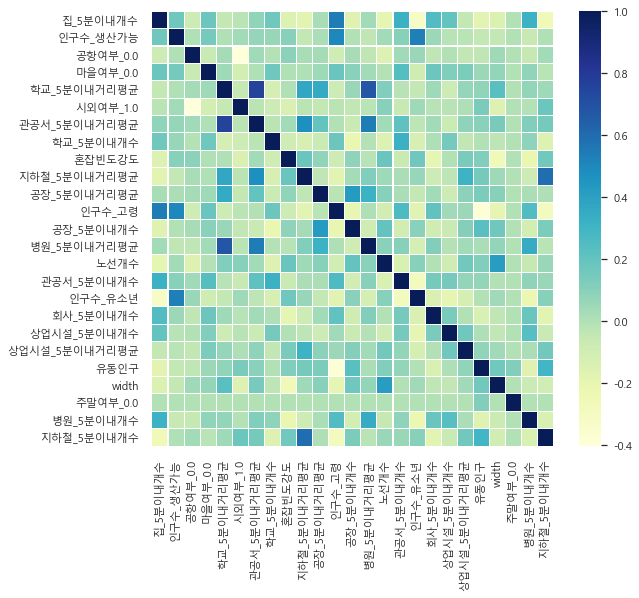

In [ ]:
corrmat = exp2[15].corr()
plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

* Cluster 2에 속하는 버스정류장들의 이용시간 모델의 Feature Importance

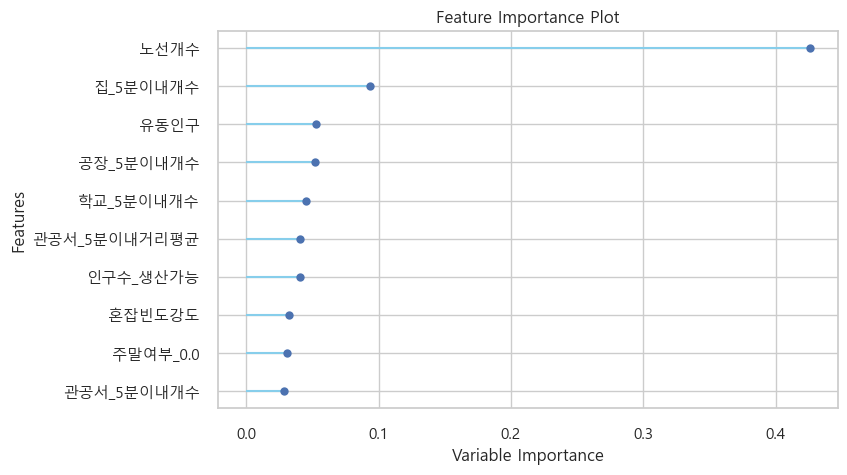

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'Malgun Gothic'
plot_model(rf_1, plot='feature')

In [ ]:
cluster1_ID = df_이용시간예측[df_이용시간예측['Cluster']==1]['정류소ID'].unique()
test_cluster1 = 이용시간_test[이용시간_test['정류소ID'].isin(cluster1_ID)]
pred_cluster1 = predict_model(rf_1, data = test_cluster1)
pred_cluster1.Label.describe()

count     4851.000000
mean      2194.930326
std       2414.282334
min          6.095250
25%        557.251189
50%       2303.584513
75%       2778.822354
max      36862.022285
Name: Label, dtype: float64

## d) Cluster 3에 속하는 버스정류장 모델링 및 예측

In [ ]:
X2 = df_이용시간예측[df_이용시간예측['Cluster']==2].drop(['일자','정류소ID','월','요일','전체 승차 건수','최종배차','lon','lat','Cluster'],axis=1)
X2

,주말여부,이용시간,혼잡시간강도,혼잡빈도강도,width,학교_5분이내거리평균,집_5분이내거리평균,회사_5분이내거리평균,공장_5분이내거리평균,상업시설_5분이내거리평균,...,병원_5분이내거리평균,병원_5분이내개수,시외여부,마을여부,공항여부,인구수_유소년,인구수_생산가능,인구수_고령,노선개수,유동인구
420,0.0,623.500000,95.035,89.60,1.0,0.003312,0.002809,0.003542,0.001537,0.0,...,0.001898,2.0,0.0,0.0,0.0,1524.0,13348.0,2263.0,1.0,98053.54
421,0.0,669.725000,95.035,89.60,1.0,0.003312,0.002809,0.003542,0.001537,0.0,...,0.001898,2.0,0.0,0.0,0.0,1524.0,13348.0,2263.0,1.0,103279.21
422,0.0,654.460000,95.035,89.60,1.0,0.003312,0.002809,0.003542,0.001537,0.0,...,0.001898,2.0,0.0,0.0,0.0,1524.0,13348.0,2263.0,1.0,101761.02
423,0.0,668.220000,95.035,89.60,1.0,0.003312,0.002809,0.003542,0.001537,0.0,...,0.001898,2.0,0.0,0.0,0.0,1524.0,13348.0,2263.0,1.0,103094.74
424,0.0,662.200000,95.035,89.60,1.0,0.003312,0.002809,0.003542,0.001537,0.0,...,0.001898,2.0,0.0,0.0,0.0,1524.0,13348.0,2263.0,1.0,102856.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57111,0.0,341.700000,67.390,36.36,3.0,0.002734,0.003260,0.003573,0.004293,0.0,...,0.002719,6.0,0.0,0.0,0.0,749.0,9541.0,1649.0,3.0,112006.74
57112,0.0,312.200000,67.390,36.36,3.0,0.002734,0.003260,0.003573,0.004293,0.0,...,0.002719,6.0,0.0,0.0,0.0,749.0,9541.0,1649.0,3.0,113343.76
57113,0.0,301.833333,67.390,36.36,3.0,0.002734,0.003260,0.003573,0.004293,0.0,...,0.002719,6.0,0.0,0.0,0.0,749.0,9541.0,1649.0,3.0,107160.25
57114,1.0,86.149662,67.390,36.36,3.0,0.002734,0.003260,0.003573,0.004293,0.0,...,0.002719,6.0,0.0,0.0,0.0,749.0,9541.0,1649.0,3.0,91854.99


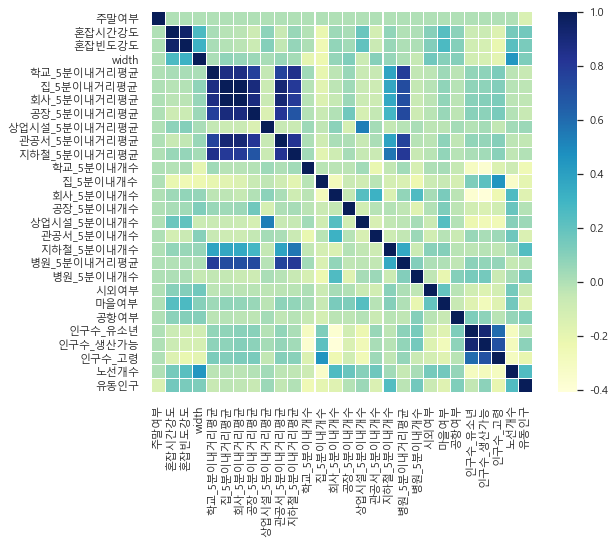

In [ ]:
# Cluster 3에 해당하는 버스정류장별 변수들의 Correlation Plot

plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 7))
sns.heatmap(X2.drop('이용시간',axis=1).corr(), linewidths = 0.1, vmax = 1.0, square = True, linecolor = "white", cmap="YlGnBu")
sns.set(rc={"axes.unicode_minus":False})

* 변수들간의 상관계수가 높아 Auto ML의 세팅에서 다중공선성 제거를 True로 두고 진행하였다. 

In [ ]:
exp3 = setup(X2, target='이용시간', normalize = True, numeric_features=['노선개수','width','상업시설_5분이내개수','공장_5분이내개수',
                                                                   '관공서_5분이내개수','지하철_5분이내개수','병원_5분이내개수'],
             feature_selection=True, verbose=True, remove_multicollinearity = True)

,Description,Value
0,session_id,5539
1,Target,이용시간
2,Original Data,"(19152, 29)"
3,Missing Values,False
4,Numeric Features,24
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(13406, 23)"


* Cluster 3의 Random Forest 학습 결과

In [ ]:
rf_2 = create_model('rf',verbose=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,280.4820,301413.3666,549.0113,0.9824,0.1668,0.1258
1,308.4967,378458.2401,615.1896,0.9835,0.1707,0.1262
2,300.1153,421382.8431,649.1401,0.9805,0.1628,0.1201
3,329.3447,589304.8241,767.6619,0.9787,0.1646,0.1211
4,312.1441,421549.8688,649.2687,0.9838,0.1662,0.1221
5,283.2176,298216.4786,546.0920,0.9863,0.1695,0.1241
6,308.7456,356230.2805,596.8503,0.9844,0.1744,0.1304
7,323.0905,449686.0581,670.5864,0.9812,0.1669,0.1250
8,291.6904,343104.7690,585.7515,0.9841,0.1666,0.1239
9,309.7700,435319.4252,659.7874,0.9829,0.1702,0.1245


* 변수간의 상관계수가 감소하여 다중공선성이 완화되었음을 알 수 있다.

<AxesSubplot:>

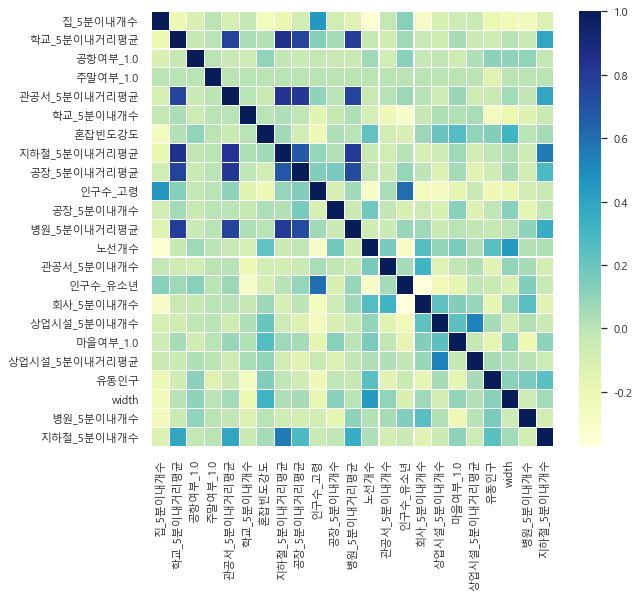

In [ ]:
corrmat = exp3[15].corr()
plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

* Cluster 3에 속하는 버스정류장들의 이용시간 모델의 Feature Importance

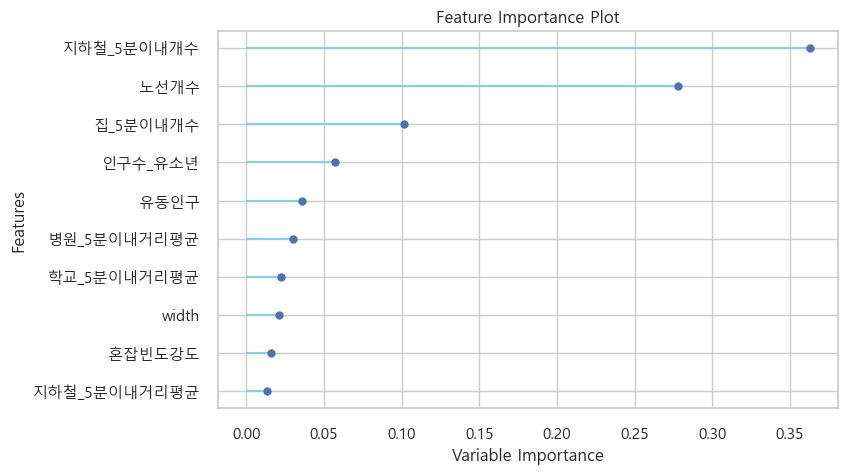

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'Malgun Gothic'
plot_model(rf_2, plot='feature')

In [ ]:
cluster2_ID = df_이용시간예측[df_이용시간예측['Cluster']==2]['정류소ID'].unique()
test_cluster2 = 이용시간_test[이용시간_test['정류소ID'].isin(cluster2_ID)]
pred_cluster2 = predict_model(rf_2, data = test_cluster2)
pred_cluster2.Label.describe()

count     4830.000000
mean      2766.960003
std       4279.301447
min         25.680320
25%        556.461113
50%       1531.834241
75%       2989.454592
max      55110.644297
Name: Label, dtype: float64

## e) 클러스터 별 예측값 결합

In [ ]:
이용시간_pred = pd.concat([pred_cluster0,pred_cluster1,pred_cluster2],axis=0).reset_index()
이용시간_pred = 이용시간_pred.groupby('정류소ID').mean().reset_index()[['정류소ID','Label']]
이용시간_pred

,정류소ID,Label
0,200000005,88.033678
1,200000006,2171.641005
2,200000007,379.843557
3,200000008,241.896727
4,200000021,310.303718
...,...,...
693,203000384,623.846355
694,203000385,203.906046
695,203000399,3737.933636
696,203000400,3581.501658


In [ ]:
이용시간_pred.to_csv("정류장별_이용시간예측.csv",index=False)

# 2) 미세먼지·초미세먼지 예측모델 및 대기실지수 생성

## a) 미세먼지 예측 모델 및 결과

In [ ]:
미세먼지_train=pd.read_csv("미세먼지_train.csv")
미세먼지_test=pd.read_csv("미세먼지_test.csv")

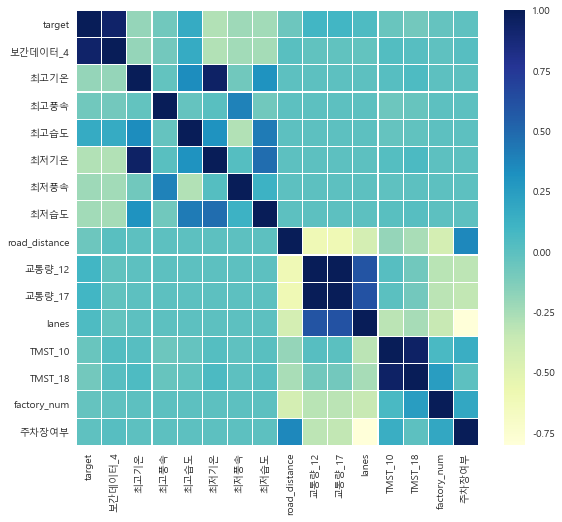

In [ ]:
# 미세먼지 예측 시 사용되는 변수들의 Correlation Plot

corrmat = 미세먼지_train.drop('측정월', axis=1).corr()
plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
sns.set(rc={"axes.unicode_minus":False})

* 변수들간의 상관계수가 높아 Auto ML의 세팅에서 다중공선성 제거를 True로 두고 진행하였다. 

In [ ]:
exp1 = setup(미세먼지_train, target = 'target',ignore_features=['날짜','측정소','측정월'],\
             normalize = True,numeric_features=['factory_num','lanes'],feature_selection=True, remove_multicollinearity=True)

,Description,Value
0,session_id,3415
1,Target,target
2,Original Data,"(2704, 19)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1892, 10)"


* 미세먼지 예측 시 LightGBM 학습 결과

In [ ]:
미세먼지=create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.3888,20.9092,4.5727,0.9409,0.1164,0.0917
1,3.3974,28.2470,5.3148,0.9097,0.1234,0.0941
2,3.7847,28.1336,5.3041,0.9272,0.1325,0.1043
3,3.9059,30.6873,5.5396,0.9245,0.1340,0.1058
4,3.4032,32.8934,5.7353,0.9018,0.1692,0.1288
5,4.2200,46.8896,6.8476,0.8879,0.1553,0.1136
6,3.8959,38.9429,6.2404,0.8913,0.1419,0.1106
7,4.0246,44.9759,6.7064,0.9056,0.1546,0.1195
8,3.7881,42.9009,6.5499,0.9071,0.1597,0.1167
9,3.8220,32.7564,5.7233,0.8977,0.1771,0.1194


* 변수간의 상관계수가 감소하여 다중공선성이 완화되었음을 알 수 있다.

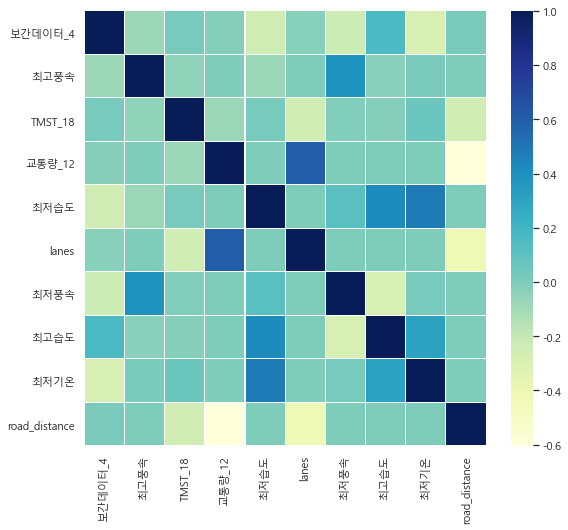

In [ ]:
corrmat = exp1[15].corr()
plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
sns.set(rc={"axes.unicode_minus":False})

* 미세먼지 농도 예측 모델의 Feature Importance

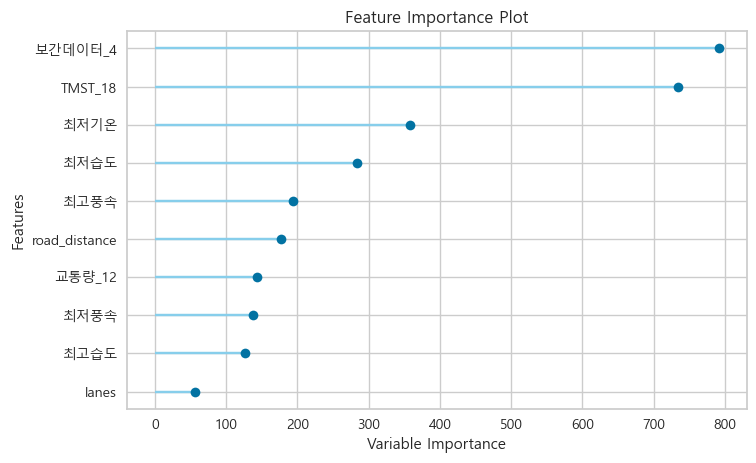

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'Malgun Gothic'  
plot_model(미세먼지,'feature')

In [ ]:
미세먼지_pred_test = predict_model(미세먼지, data = 미세먼지_test)
미세먼지_pred_test['target'] = 미세먼지_pred_test['Label']

* 미세먼지 농도에 따른 등급 할당

In [ ]:
미세먼지_pred_test['미세등급']=0

for i in range(len(미세먼지_pred_test)):
    if 미세먼지_pred_test['target'][i]<31:
        미세먼지_pred_test['미세등급'][i] = 1
    elif 미세먼지_pred_test['target'][i]<81:
        미세먼지_pred_test['미세등급'][i] = 2
    elif 미세먼지_pred_test['target'][i]<151:
        미세먼지_pred_test['미세등급'][i] = 3
    else:
        미세먼지_pred_test['미세등급'][i] = 4

## b) 초미세먼지 예측 모델 및 결과

In [ ]:
초미세먼지_train=pd.read_csv("초미세먼지_train.csv")
초미세먼지_test=pd.read_csv("초미세먼지_test.csv")

<AxesSubplot:>

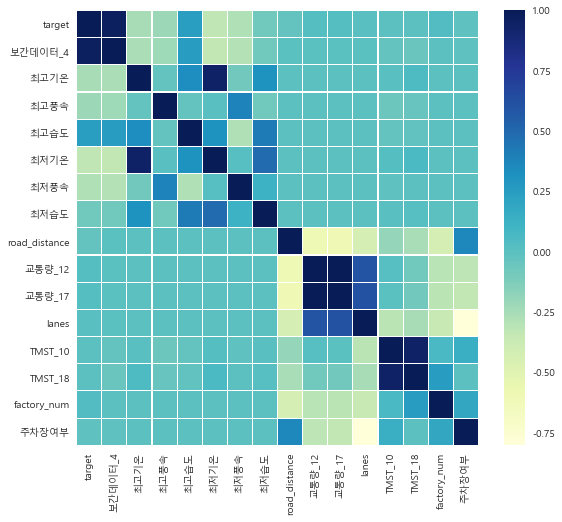

In [ ]:
# 초미세먼지 예측 시 사용되는 변수들의 Correlation Plot

corrmat = 초미세먼지_train.drop('측정월', axis=1).corr()
plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

* 변수들간의 상관계수가 높아 Auto ML의 세팅에서 다중공선성 제거를 True로 두고 진행하였다. 

In [ ]:
exp2 = setup(초미세먼지_train, target = 'target',ignore_features=['날짜','측정소','측정월'],\
             normalize = True, numeric_features=['factory_num','lanes'],feature_selection=True,remove_multicollinearity=True)

,Description,Value
0,session_id,8176
1,Target,target
2,Original Data,"(2712, 19)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1898, 10)"


* 초미세먼지 예측 시 LightGBM 학습 결과

In [ ]:
초미세먼지=create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.8500,6.3662,2.5231,0.9650,0.1476,0.1315
1,1.6756,6.3207,2.5141,0.9642,0.1559,0.1202
2,1.6729,6.4120,2.5322,0.9654,0.1561,0.1107
3,2.0173,11.9085,3.4509,0.9352,0.1424,0.1109
4,1.9092,7.0368,2.6527,0.9509,0.1368,0.1128
5,2.0042,9.0247,3.0041,0.9509,0.1485,0.1484
6,2.1343,10.4673,3.2353,0.9383,0.1429,0.1169
7,1.8101,6.9511,2.6365,0.9596,0.1600,0.1304
8,1.9179,8.4073,2.8995,0.9636,0.1558,0.1254
9,1.8812,6.8126,2.6101,0.9600,0.2043,0.2688


* 변수간의 상관계수가 감소하여 다중공선성이 완화되었음을 알 수 있다.

<AxesSubplot:>

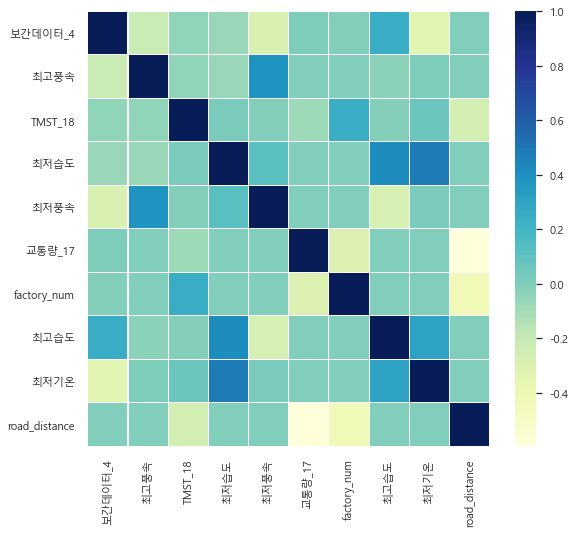

In [ ]:
corrmat = exp2[15].corr()
plt.rcParams["font.family"] = 'Malgun Gothic'  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

* 초미세먼지 농도 예측 모델의 Feature Importance

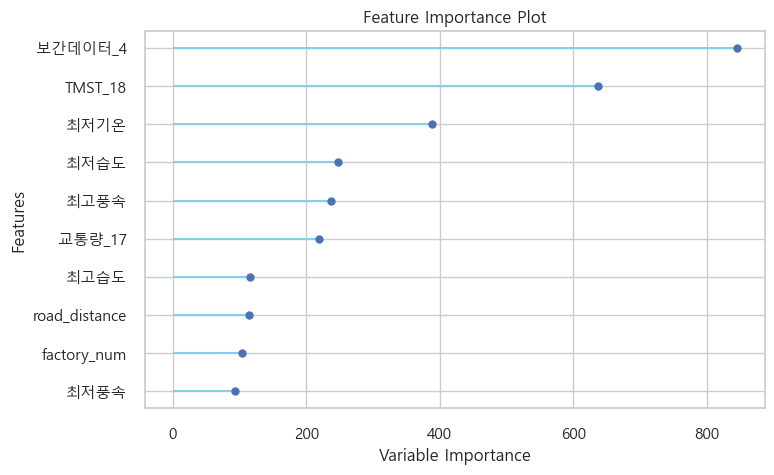

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'Malgun Gothic'  
plot_model(초미세먼지,'feature_all')

In [ ]:
초미세먼지_pred_test = predict_model(초미세먼지, data = 초미세먼지_test)
초미세먼지_pred_test['target'] = 초미세먼지_pred_test['Label']

In [ ]:
# 초미세먼지 농도에 따른 등급 할당

초미세먼지_pred_test['초미세등급']=0

for i in range(len(초미세먼지_pred_test)):
    if 초미세먼지_pred_test['target'][i]<16:
        초미세먼지_pred_test['초미세등급'][i] = 1
    elif 초미세먼지_pred_test['target'][i]<51:
        초미세먼지_pred_test['초미세등급'][i] = 2
    elif 초미세먼지_pred_test['target'][i]<101:
        초미세먼지_pred_test['초미세등급'][i] = 3
    else:
        초미세먼지_pred_test['초미세등급'][i] = 4

## c) 예측된 미세먼지 · 초미세먼지를 이용하여 일별 미세먼지 등급 도출

In [ ]:
미세먼지등급 = pd.merge(미세먼지_pred_test[['날짜','정류소ID','미세등급']],초미세먼지_pred_test[['날짜','정류소ID','초미세등급']],on=['날짜','정류소ID'],how = 'inner')
미세먼지등급['최종등급']=0
for i in range(len(미세먼지등급)):
    미세먼지등급['최종등급'][i] = max(미세먼지등급['미세등급'][i],미세먼지등급['초미세등급'][i])

미세먼지등급

,날짜,정류소ID,미세등급,초미세등급,최종등급
0,2020-01-01,201000055,2,2,2
1,2020-01-02,201000055,2,2,2
2,2020-01-03,201000055,3,3,3
3,2020-01-04,201000055,2,2,2
4,2020-01-05,201000055,2,2,2
...,...,...,...,...,...
243881,2020-12-27,202000246,3,2,3
243882,2020-12-28,202000246,3,3,3
243883,2020-12-29,202000246,2,3,3
243884,2020-12-30,202000246,2,1,2


In [ ]:
# 미세먼지 '나쁨'(최종등급이 3이상)인 비율 계산

미세먼지_최종등급=pd.merge(미세먼지등급.groupby('정류소ID').count().reset_index(),미세먼지등급[미세먼지등급['최종등급']>=3].groupby('정류소ID').count().reset_index(), on='정류소ID', how='inner')
미세먼지_최종등급['최종등급']=미세먼지_최종등급['최종등급_y']/미세먼지_최종등급['최종등급_x']

In [ ]:
미세먼지_최종등급.to_csv("미세먼지_최종등급.csv",index=False)